In [1]:
import numpy as np 
import datetime
import matplotlib.pyplot as plt 
from astropy.table import Table, join, unique
from astropy import units as u
from astropy import constants as const
from matplotlib.ticker import MultipleLocator
from edge_pydb import EdgeTable
from matplotlib.backends.backend_pdf import PdfPages

# Display and analysis of EDGE CO rotation curves

## Combine list of RINGFIT and Bbarolo galaxies

In [2]:
bbtable1 = EdgeTable('bb_natv_fitvd_dilmsk.csv')
bblist1  = unique(bbtable1.table, keys='Name').columns[0].tolist()
print(len(bblist1),' galaxies in bbtable1')

bbtable2 = EdgeTable('bb_natv_fixvd_dilmsk.csv')
bblist2  = unique(bbtable2.table, keys='Name').columns[0].tolist()
print(len(bblist2),' galaxies in bbtable2')

rftable = EdgeTable('rf_CO_natv.csv')
rflist = unique(rftable.table, keys='Name').columns[0].tolist()
print(len(rflist),' galaxies in rftable')
rfpars = EdgeTable('edge_rfpars.csv')
rftable.join(rfpars)

jamtable = EdgeTable('jam_rotcurves.csv')
jamlist = unique(jamtable.table, keys='Name').columns[0].tolist()
print(len(jamlist),' galaxies in jamtable')
jampars = EdgeTable('edge_jampars.csv')
jamtable.join(jampars)

gallist = sorted(list(set(rflist)-set(bblist1)) + bblist1)
print(len(gallist),' galaxies in total')

79  galaxies in bbtable1
79  galaxies in bbtable2
104  galaxies in rftable
54  galaxies in jamtable
105  galaxies in total


## Display physical resolution of sample

63.49502196 1.4073491934128215 2.1548258488837178


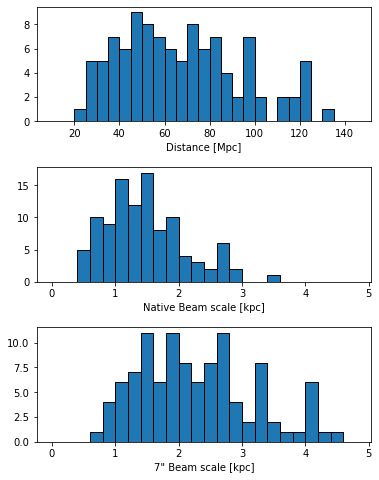

In [3]:
califa = EdgeTable('edge_califa.csv')
coobs  = EdgeTable('edge_coobs_DE.csv')
califa.join(coobs)
califa.add_index('Name')
chose = [califa['Name'].tolist().index(i) for i in gallist]
galdist = califa['caDistMpc'][chose]
natbeam = np.sqrt(califa['coDEbmaj'][chose]*califa['coDEbmin'][chose])
beam5 = galdist*natbeam/206.265
beam7 = galdist*7/206.265
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6,8))
ax1.hist(galdist,bins=np.arange(10, 150, 5), ec='black')
ax1.set_xlabel('Distance [Mpc]')
ax2.hist(beam5,bins=np.arange(0, 5, 0.2), ec='black')
ax2.set_xlabel('Native Beam scale [kpc]')
ax3.hist(beam7,bins=np.arange(0, 5, 0.2), ec='black')
ax3.set_xlabel('7" Beam scale [kpc]')
fig.subplots_adjust(hspace=0.4)
print(np.median(galdist),np.median(beam5),np.median(beam7))

## Plot the native resolution rotation curves

In [4]:
parset0 = [True, False, False, 'arc', 40, 6, 5, '']
parset1 = [True, False, True, 'arc', 40, 6, 5, 'edge_vrot.pdf']
parset2 = [True, True, True, 'arc', 40, 6, 5, 'edge_vrotsini.pdf']
parset3 = [True, True, True, 'kpc', 15, 6, 5, 'edge_vrot_kpc.pdf']
fitvd, proj, pdfout, xtype, xmax, nx, ny, outname = parset0

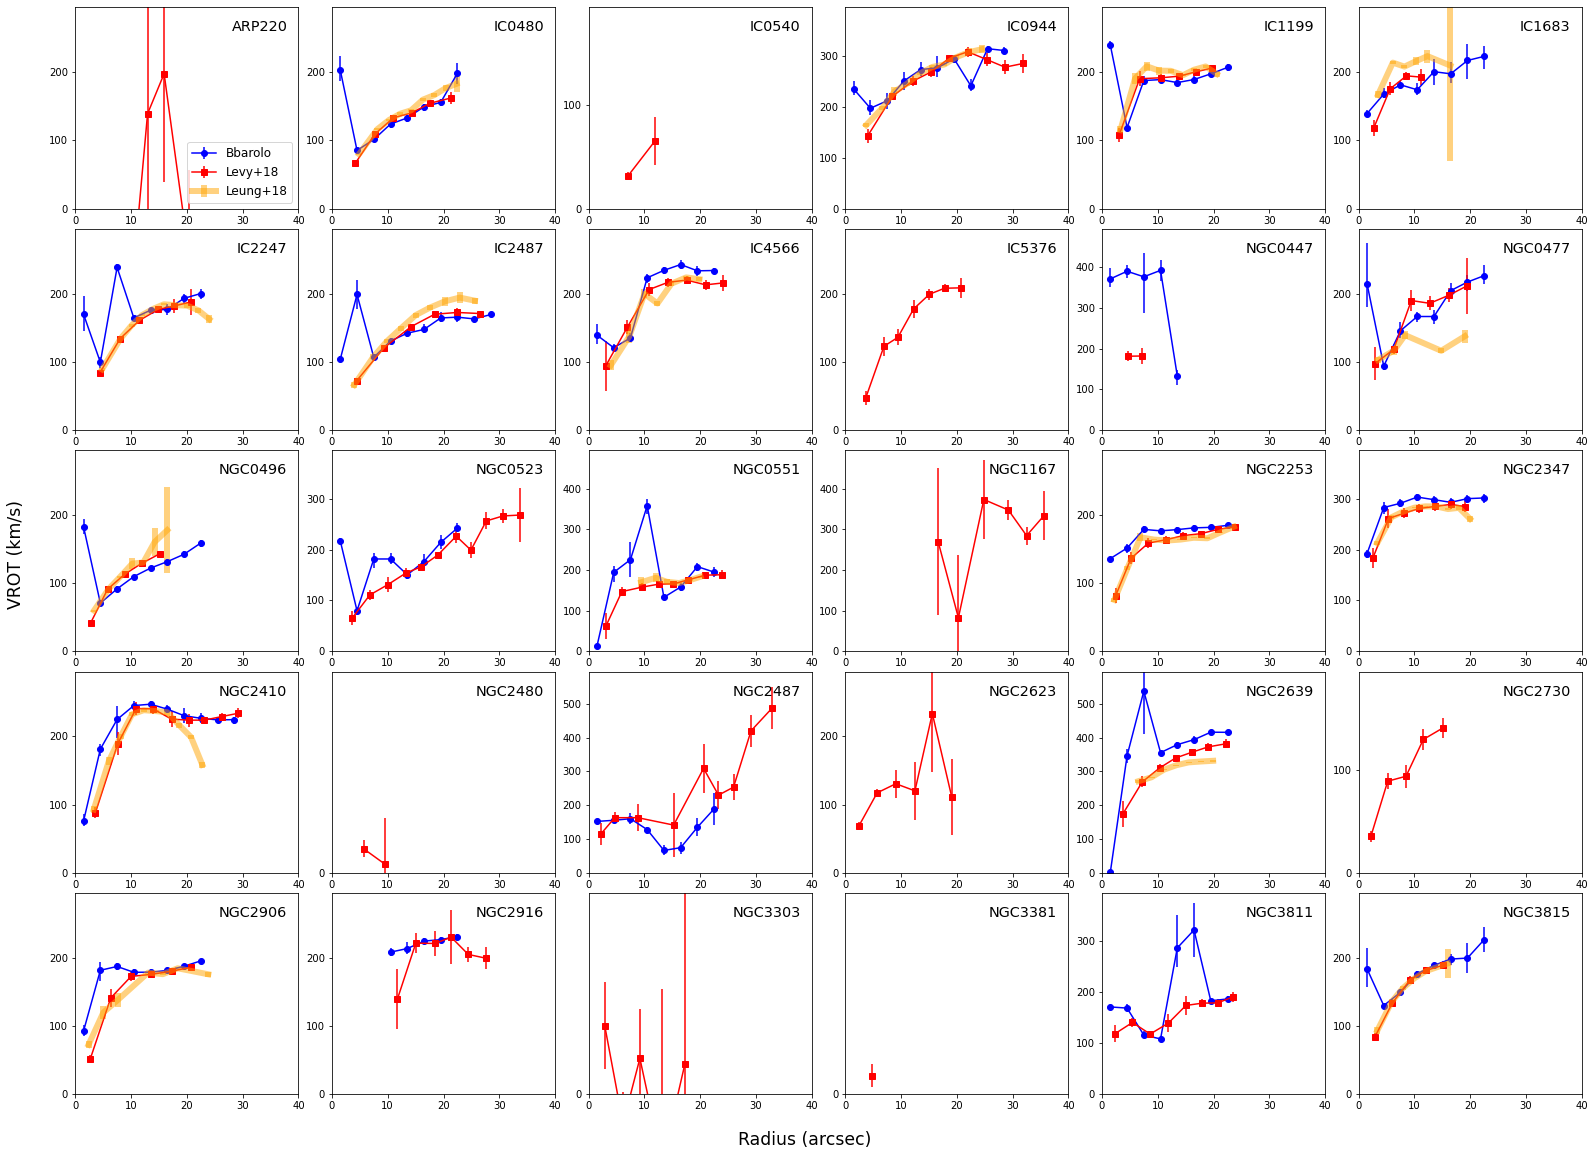

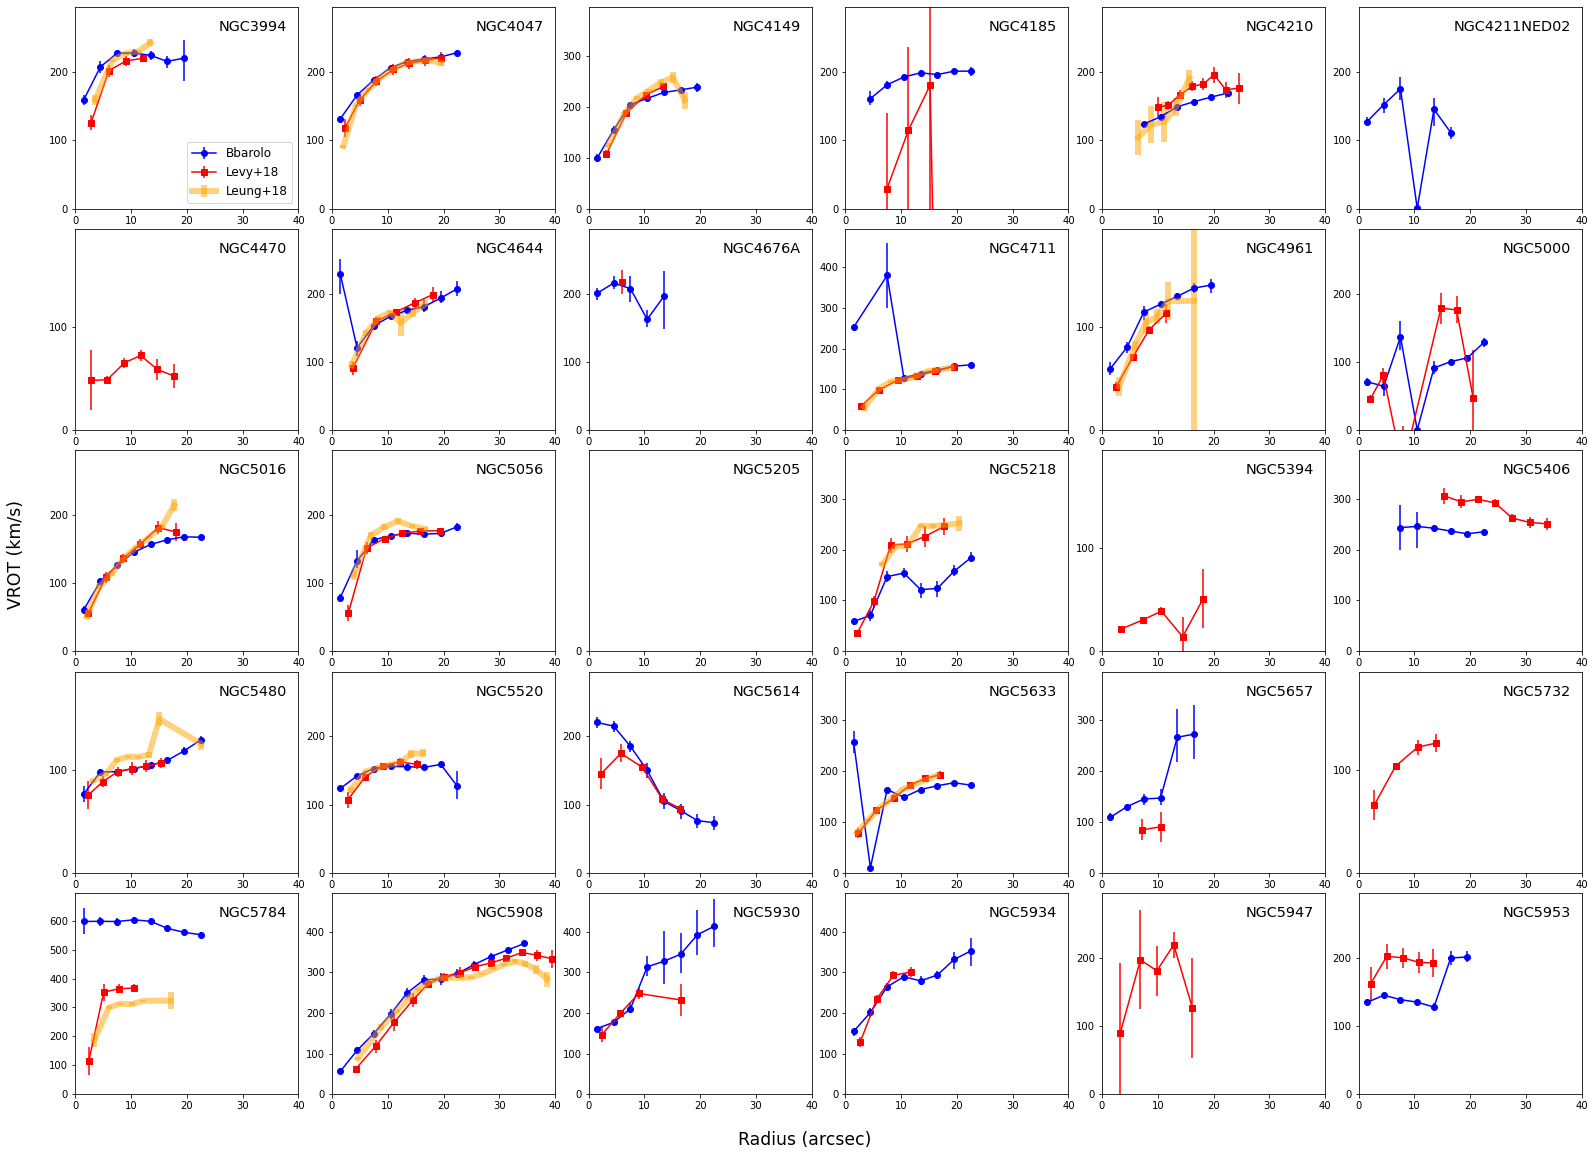

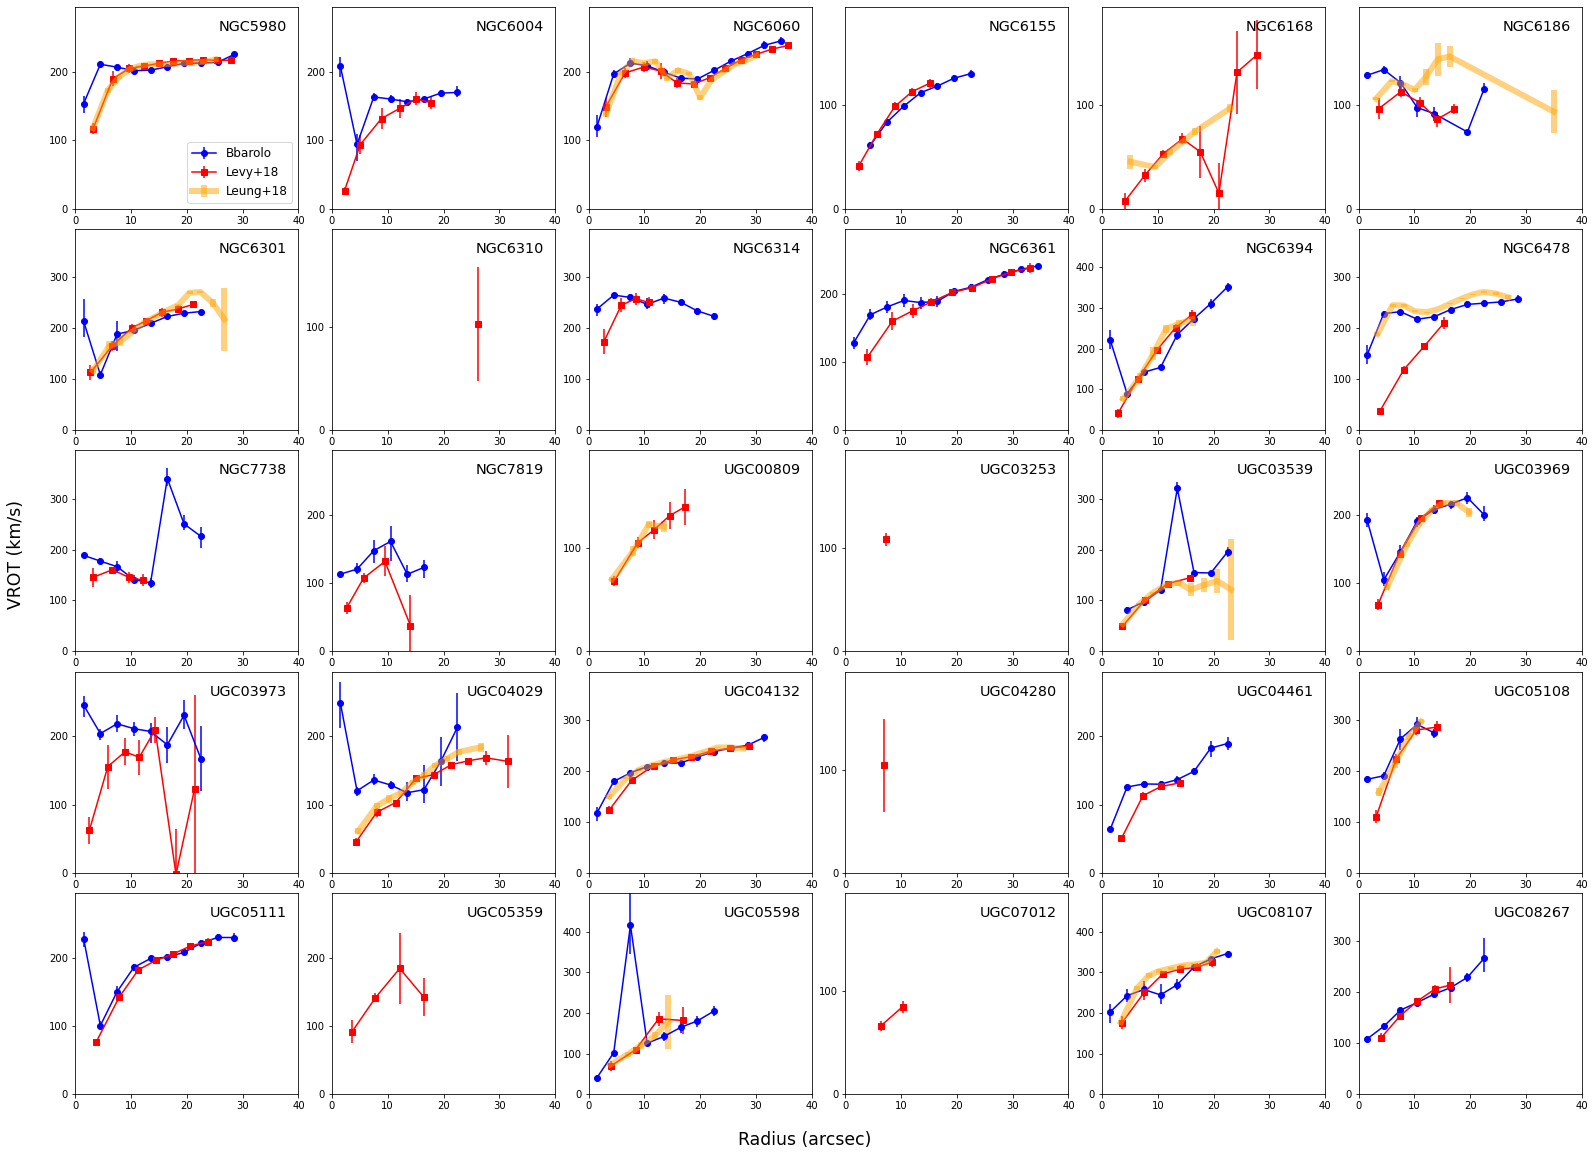

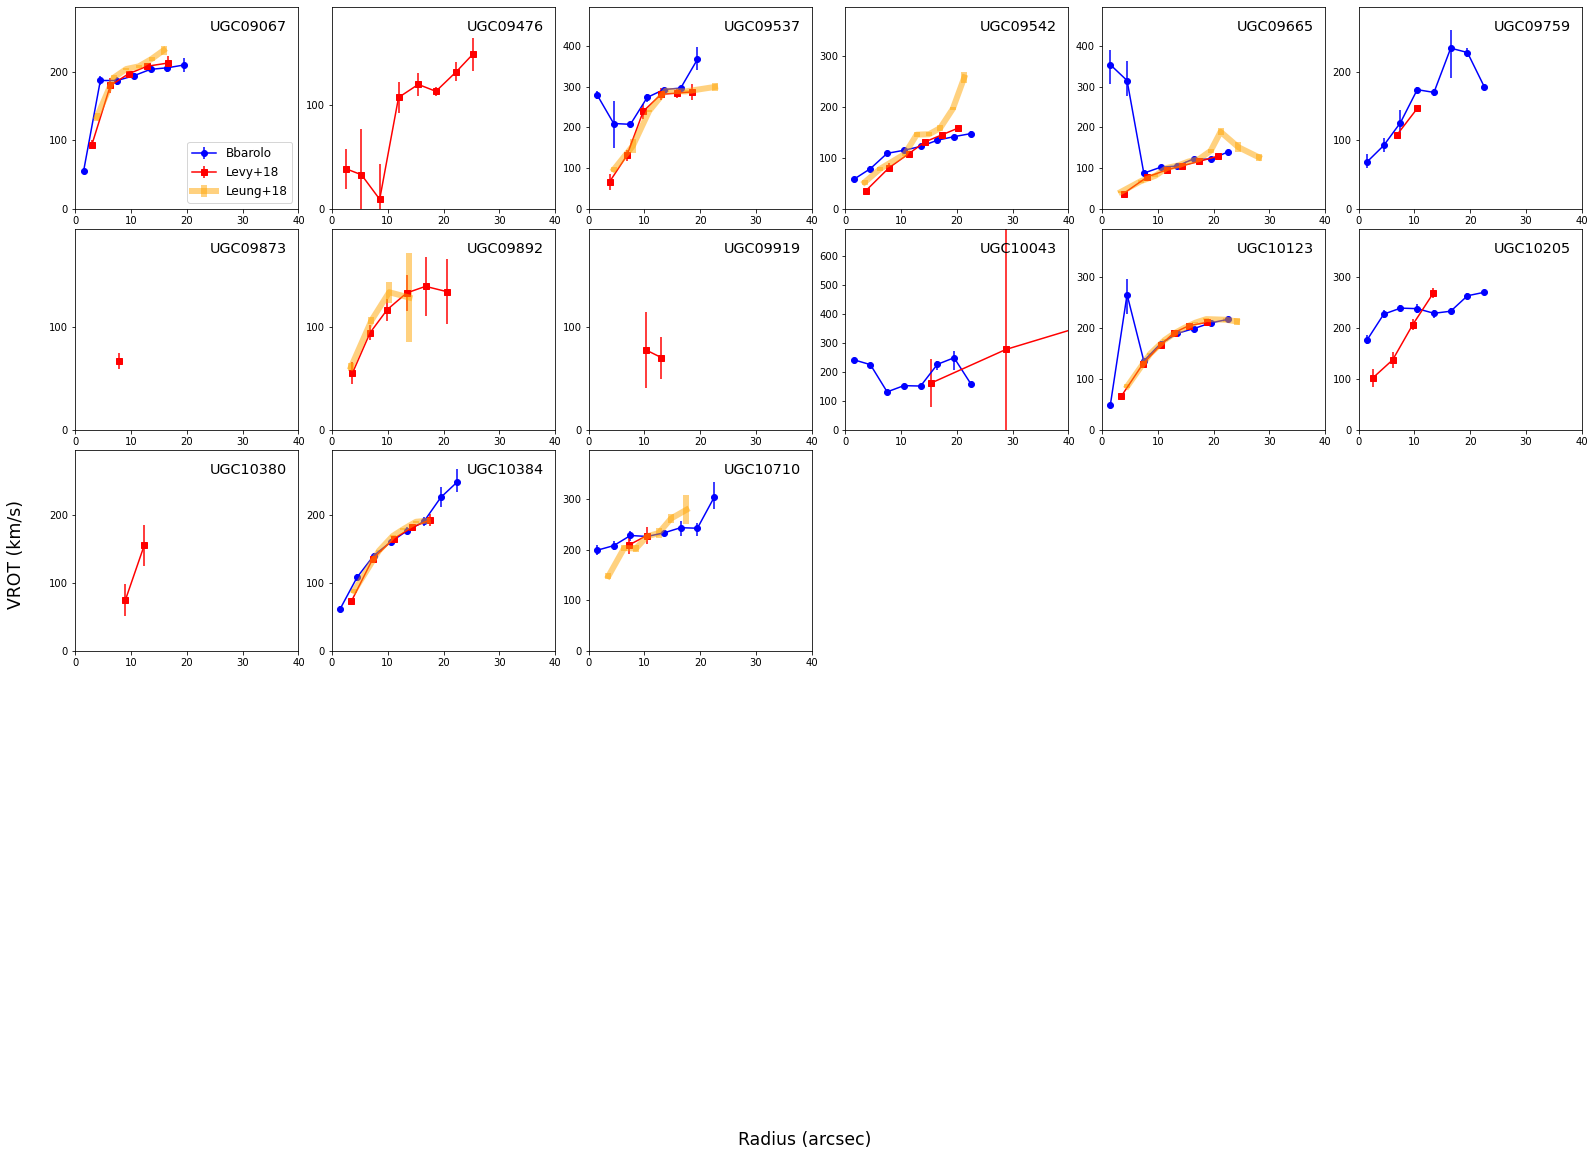

In [5]:
if fitvd:
    bbtable = bbtable1
else:
    bbtable = bbtable2

pages = int(np.ceil(float(len(gallist)) / (nx*ny)))

if pdfout:
    pp = PdfPages(outname)

for num in range(0,pages):
    aa = nx*ny*num
    bb = nx*ny+aa
    sublist = gallist[aa:bb]
    fig = plt.figure(0)
    fig.set_size_inches(nx*4.5, ny*4.)
    for idx, gal in enumerate(sublist):
        bbrows = bbtable[bbtable['Name']==gal]
        rfrows = rftable[rftable['Name']==gal]
        rfrows.sort('radius')
        jamrows = jamtable[jamtable['Name']==gal]
        jamrows.sort('radius')
        row, col = divmod(idx,nx)
        ax = plt.subplot2grid((ny,nx),(row,col))
        # --- for choosing the y-limits
        ymax = 0
        for i, vec in enumerate([bbrows['bbVrot'], rfrows['Vrot'], jamrows['Vrot']]):
            if len(vec) > 0:
                ymax = max(ymax, vec.max())
        ymax = min(700,100*np.ceil(0.5+ymax/100))-5
        # --- for scaling VROT by sin(i)
        scl = [1, 1, 1]
        for i, vec in enumerate([bbrows['bbInc'], rfrows['rfInc'], jamrows['jaIncl']]):
            if proj and len(vec) > 0:
                scl[i] = np.sin(np.radians(vec[0]))
        # --- for scaling to kpc
        if xtype == 'kpc':
            as2kpc = califa.loc[gal]['caDistMpc']/206.265
            for vec in [bbrows['bbRad'], rfrows['radius'], jamrows['radius']]:
                if len(vec) > 0:
                    vec *= as2kpc
        # --- plot the rotation curves
        ax.errorbar(bbrows['bbRad'],bbrows['bbVrot']*scl[0],
                    yerr=[abs(bbrows['bbVrot_e1']*scl[0]),bbrows['bbVrot_e2']*scl[0]],
                    c='b',marker='o',label='Bbarolo')
        ax.errorbar(rfrows['radius'],rfrows['Vrot']*scl[1],yerr=rfrows['e_Vrot']*scl[1],
                    c='r',marker='s',label='Levy+18')
        ax.errorbar(jamrows['radius'],jamrows['Vrot']*scl[2],yerr=jamrows['e_Vrot']*scl[2],
                    c='orange',lw=6,alpha=0.5,label='Leung+18')
        #ax.errorbar(jamrows['radius'],jamrows['Vrot_bsc'],yerr=jamrows['e_Vrot_bsc'],
        #            c='green',lw=6,alpha=0.5,label='Leung+18bsc')
        ax.set_xlim([0,xmax])
        ax.set_ylim([0, ymax])
        ax.yaxis.set_major_locator(MultipleLocator(100))
        if row == 0 and col == 0:
            ax.legend(loc='lower right',fontsize='large')
        #if (row != ny-1):
        #    ax.xaxis.set_ticks([])
        #if (col != 0):
        #    ax.yaxis.set_ticks([])
        plt.text(0.95,0.9,gal,ha='right',va='center',transform=ax.transAxes,
           fontsize='x-large')

    fig.subplots_adjust(hspace=0.1)
    fig.subplots_adjust(wspace=0.15)
    if xtype == 'kpc':
        fig.text(0.5, 0.09, 'Radius (kpc)', ha='center', fontsize='xx-large')
    else:
        fig.text(0.5, 0.09, 'Radius (arcsec)', ha='center', fontsize='xx-large')
    if proj:
        ytxt = 'VROT sin(i)'
    else:
        ytxt = 'VROT'
    fig.text(0.09, 0.5, ytxt+' (km/s)', va='center', rotation='vertical', 
                fontsize='xx-large')
    if pdfout:
        pp.savefig(bbox_inches = 'tight', pad_inches=0.1)
        plt.close()
    else:
        plt.show()

if pdfout:
    d = pp.infodict()
    d['Title'] = 'EDGE Gallery'
    d['Author'] = 'Tony Wong'
    d['CreationDate'] = datetime.datetime.today()
    pp.close()

## Bbarolo results for full sample

In [6]:
def readcurve(gal, tablename):
    table = EdgeTable(tablename)
    galrows = table[table['Name']==gal]
    rad  = galrows['bbRad']
    vrot = galrows['bbVrot']
    disp = galrows['bbVdisp']
    vrot_mi = galrows['bbVrot_e1']
    vrot_pl = galrows['bbVrot_e2']
    disp_mi = galrows['bbVdisp_e1']
    disp_pl = galrows['bbVdisp_e2']
    return [rad, vrot, vrot_mi, vrot_pl, disp, disp_mi, disp_pl]

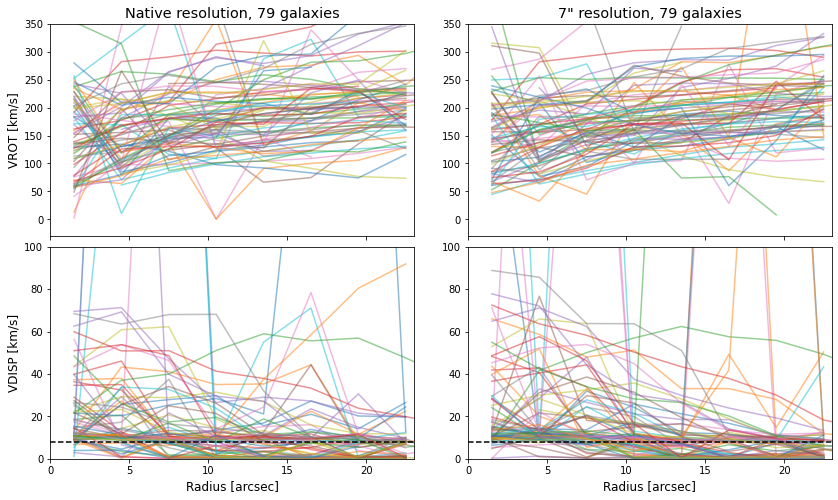

In [7]:
fig, axarr = plt.subplots(2,2,sharex=True,figsize=(14,8))
ngal = 0
for gal in bblist1:
    dat5 = readcurve(gal, 'bb_natv_fitvd_dilmsk.csv')
    axarr[0,0].plot(dat5[0], dat5[1], label=gal, alpha=0.5)
    axarr[1,0].plot(dat5[0], dat5[4], label=gal, alpha=0.5)
    dat7 = readcurve(gal, 'bb_smo7_fitvd_dilmsk.csv')
    axarr[0,1].plot(dat7[0], dat7[1], label=gal, alpha=0.5)
    axarr[1,1].plot(dat7[0], dat7[4], label=gal, alpha=0.5)
    ngal += 1
# Upper left
axarr[0,0].set_title('Native resolution, {} galaxies'.format(ngal),fontsize='x-large')
axarr[0,0].set_ylim(-30,350)
axarr[0,0].set_xlim(0,23)
axarr[0,0].set_ylabel('VROT [km/s]',fontsize='large')
# Lower left
axarr[1,0].axhline(8, color='k', ls='--')
axarr[1,0].set_xlabel('Radius [arcsec]',fontsize='large')
axarr[1,0].set_ylabel('VDISP [km/s]',fontsize='large')
axarr[1,0].set_ylim(0,100)
# Upper right
axarr[0,1].set_title('7" resolution, {} galaxies'.format(ngal),fontsize='x-large')
axarr[0,1].set_ylim(-30,350)
# Lower right
axarr[1,1].axhline(8, color='k', ls='--')
axarr[1,1].set_xlabel('Radius [arcsec]',fontsize='large')
axarr[1,1].set_ylim(0,100)
fig.subplots_adjust(hspace=0.05)
fig.subplots_adjust(wspace=0.15)

## Effect of resolution on Bbarolo results

In [8]:
highres = ['IC1199','IC1683','IC2247','NGC2347','NGC2410','NGC3815',
           'NGC5520','NGC5633','NGC5908','NGC5934','NGC5980','NGC6060',
           'NGC6314','NGC6478','UGC10123']
res7 = ['IC0944','NGC0496','NGC2253','NGC2639','NGC2906','NGC3811',
        'NGC3994','NGC4047','NGC4149','NGC5016','NGC5056','NGC5614',
        'NGC5953','NGC6004','NGC6301','NGC6361','NGC7738','UGC04132',
        'UGC05111','UGC09067','UGC10043','UGC10710']

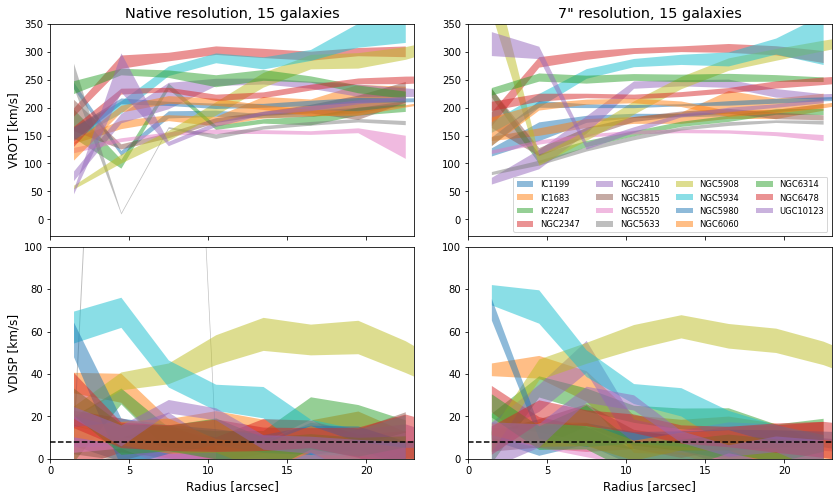

In [9]:
fig, axarr = plt.subplots(2,2,sharex=True,figsize=(14,8))
ngal = 0
for gal in highres:
    dat5 = readcurve(gal, 'bb_natv_fitvd_dilmsk.csv')
    axarr[0,0].fill_between(dat5[0], dat5[1]+dat5[2], dat5[1]+dat5[3], label=gal, alpha=0.5)
    axarr[1,0].fill_between(dat5[0], dat5[4]+dat5[5], dat5[4]+dat5[6], label=gal, alpha=0.5)
    dat7 = readcurve(gal, 'bb_smo7_fitvd_dilmsk.csv')
    axarr[0,1].fill_between(dat7[0], dat7[1]+dat7[2], dat7[1]+dat7[3], label=gal, alpha=0.5)
    axarr[1,1].fill_between(dat7[0], dat7[4]+dat7[5], dat7[4]+dat7[6], label=gal, alpha=0.5)
    ngal += 1
# Upper left
axarr[0,0].set_title('Native resolution, {} galaxies'.format(ngal),fontsize='x-large')
axarr[0,0].set_ylim(-30,350)
axarr[0,0].set_xlim(0,23)
axarr[0,0].set_ylabel('VROT [km/s]',fontsize='large')
# Lower left
axarr[1,0].axhline(8, color='k', ls='--')
axarr[1,0].set_xlabel('Radius [arcsec]',fontsize='large')
axarr[1,0].set_ylabel('VDISP [km/s]',fontsize='large')
axarr[1,0].set_ylim(0,100)
# Upper right
axarr[0,1].set_title('7" resolution, {} galaxies'.format(ngal),fontsize='x-large')
axarr[0,1].set_ylim(-30,350)
axarr[0,1].legend(loc="lower right",ncol=4,fontsize='small')
# Lower right
axarr[1,1].axhline(8, color='k', ls='--')
axarr[1,1].set_xlabel('Radius [arcsec]',fontsize='large')
axarr[1,1].set_ylim(0,100)
fig.subplots_adjust(hspace=0.05)
fig.subplots_adjust(wspace=0.15)

## Toomre Q parameter

In [10]:
def kappa(v_c, R):
    dv_c = (v_c.to(u.km/u.s)).value
    #dv_c_err = (v_c_err.to(u.km/u.s)).value
    dR=(R.to(u.km)).value
    deriv = np.gradient(dv_c,dR)/u.s
    #deriv_err = np.gradient(dv_c_err,dR)/u.s
    kappa_sqr = 2*v_c/R*(deriv+v_c/R)
    for n in range(len(kappa_sqr)):
        if kappa_sqr[n] < 0:
            kappa_sqr[n]=np.nan
    kappa_out = np.sqrt(kappa_sqr)
    #kappa_err = kappa_out**-1*np.sqrt((v_c_err/R*(deriv+v_c/R))**2+(v_c/R*(deriv_err+v_c_err/R))**2) 
    return kappa_out

def Sigma_crit(c_g, kappa):
    output = (kappa*c_g/np.pi/const.G).to(u.solMass/u.pc**2)
    return output

def jytok(jy, bmaj=1*u.arcsec, bmin=1*u.arcsec, freq=115.27*u.GHz):
    #omega_B = np.pi/(4*np.log(2)) * bmaj * bmin 
    # use 1 square arcsecond as the beam size
    omega_B = bmaj * bmin 
    convfac = (u.Jy).to(u.K, equivalencies=u.brightness_temperature(freq,omega_B))
    return jy*convfac

def Qcalc(gal, tablename, dmpc):
    alphaco = 4.3 * u.solMass * u.s / (u.K * u.km * u.pc**2)
    table = EdgeTable(tablename)
    galrows = table[table['Name']==gal]
    rkpc  = (galrows['bbRad']*dmpc).to(u.kpc, equivalencies=u.dimensionless_angles())
    vrot = galrows['bbVrot']
    disp = galrows['bbVdisp']
    sigcrit = Sigma_crit(disp, kappa(vrot,rkpc))
    dproj = jytok(galrows['bbIntens']*np.cos(galrows['bbInc']))
    siggas = np.array(dproj)*u.km/u.s*u.K*alphaco
    return rkpc, sigcrit/siggas

Text(0, 0.5, '$Q_{gas}$')

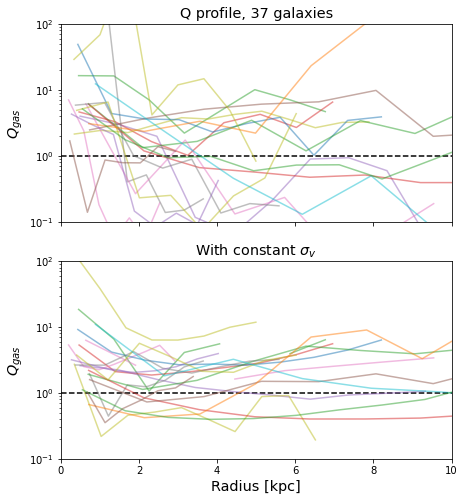

In [11]:
fig, axarr = plt.subplots(2,1,sharex=True,figsize=(7,8))
ngal = 0
for gal in highres+res7:
    dmpc = califa.loc[gal]['caDistMpc']*u.Mpc
    dat1 = Qcalc(gal, 'bb_natv_fitvd_dilmsk.csv', dmpc)
    axarr[0].plot(dat1[0], dat1[1], label=gal, alpha=0.5, marker=None)
    dat2 = Qcalc(gal, 'bb_natv_fixvd_dilmsk.csv', dmpc)
    axarr[1].plot(dat2[0], dat2[1], label=gal, alpha=0.5, marker=None)
    ngal += 1
# Upper
axarr[0].set_title('Q profile, {} galaxies'.format(ngal),fontsize='x-large')
axarr[0].set_yscale('log')
axarr[0].set_ylim(0.1,100)
axarr[0].axhline(1, color='k', ls='--', zorder=-2)
axarr[0].set_ylabel('$Q_{gas}$',fontsize='x-large')
axarr[0].set_xlim(0,10)
# Lower
axarr[1].set_title('With constant $\sigma_v$',fontsize='x-large')
axarr[1].set_yscale('log')
axarr[1].set_ylim(0.1,100)
axarr[1].axhline(1, color='k', ls='--', zorder=-2)
axarr[1].set_xlabel('Radius [kpc]',fontsize='x-large')
axarr[1].set_ylabel('$Q_{gas}$',fontsize='x-large')
#fig.subplots_adjust(hspace=0.05)